In [1]:
import os
import sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), '..'))
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

import time

from efficientnet.tfkeras import EfficientNetB4
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, DetrForSegmentation, DetrFeatureExtractor
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

from Utilities.utilities import *
from Utilities.lime_segmentation import *


/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    
    "XAI_algorithm": {
        "DSEG" : True,
        "LIME" : True,
        "SLIME" : True,
        "BayesLime" : True,
        "GLIME" : True,
    },

    'computation':{
        'num_workers': 3,
        'gpu_device': False,
        'gpu_num': "4",
    },
    
        
    'model_to_explain':{
        'EfficientNet' : True,
        'ResNet': False,
        'VisionTransformer': False,
    },
    
    'lime_segmentation':{
        #Lime Parameters
        'num_samples': 256,
        'num_features': 1000,
        'min_weight': 0.01,
        'top_labels': 1,
        'hide_color': None,
        'batch_size': 10,
        'verbose': True,
        
        'slic': True,
        'quickshift': False,
        'felzenszwalb': False,
        'watershed': False,
        
        'all_dseg': False,
        'DETR' : False,
        'SAM' : True,
        'points_per_side' : 32,
        'min_size': 512,
        
        'fit_segmentation' : True,        
        'slic_compactness' : 16,
        'num_segments': 20,
        'markers' : 16,
        'kernel_size' : 6,
        'max_dist' : 32,
        
        #Lime Segmentation Parameters
        'iterations': 1,
        'shuffle': False,
        'max_segments': 8,
        'min_segments': 1,
        'auto_segment': False, 
        
        # LIME Explanation Parameters
        "num_features_explanation": 2,
        "adaptive_num_features": False,
        "adaptive_fraction": True,
        
        'hide_rest': True,
        'positive_only': True,
        
    },
    
    "evaluation": {
        'noisy_background': True,
        
        #Correctness
        "model_randomization" : False,
        "explanation_randomization" : True,
        
        "single_deletion": False,
        "fraction" : 0.1,
        "fraction_std" : 0.05,
        
        "incremental_deletion": False,
        "incremental_deletion_fraction": 0.15,
        
        "stability": False,
        "repetitions": 8,
        
        #Output Completeness
        "preservation_check": False,
        "deletion_check": False,
        
        #Consistency
        "variation_stability": False,
        
        #Contrastivity
        "target_discrimination": False,
        "data_randomization": False,
        
        #Covariate Complexity
        "covariate_homogeneity": False,
        
        #Compactness
        "size": False,
        
        #Confidence
        "confidence": False,
        
        #Coherence
        "alignment": False,
    }
}


from Utilities.utilities import *
from Utilities.lime_utilities import *
from Utilities.lime_segmentation import *
from Utilities.lime_base import *
from Utilities.GLIME import *

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = config['computation']['gpu_num'] if config['computation']['gpu_device'] else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if config['computation']['gpu_device'] else ''

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if config['computation']['gpu_device'] else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if config['computation']['gpu_device'] else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

if config['model_to_explain']['EfficientNet']: 
    model_explain = EfficientNetB4(weights='imagenet')
    model_explain_processor = None 
elif config['model_to_explain']['ResNet']:
    model_explain = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    model_explain.eval()
    model_explain_processor = None
elif config['model_to_explain']['VisionTransformer']:
    model_explain_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
    model_explain = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

if config['lime_segmentation']['DETR']:
    feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
    model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

else:
    sam_checkpoint = "../Models/pretrained/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    if config['computation'].get('gpu_device'):
        model.to(device="cuda:0")
    else:
        model.to(device="cpu")

    feature_extractor = SamAutomaticMaskGenerator(model,
                                            min_mask_region_area=config['lime_segmentation']['min_size'],
                                            points_per_side=config['lime_segmentation']['points_per_side'],
                                            )
   
    

2024-03-07 15:42:53.082403: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


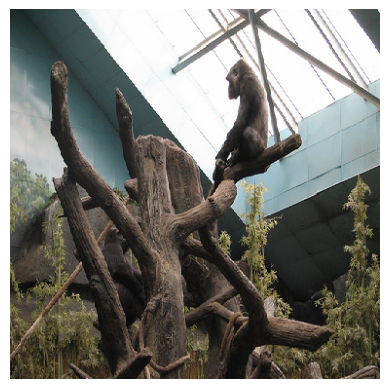

[[('n02480855', 'gorilla', 0.60311544), ('n02486410', 'baboon', 0.19507387), ('n02487347', 'macaque', 0.018075733), ('n02483362', 'gibbon', 0.007005612), ('n02481823', 'chimpanzee', 0.005813234)]]


[[('n02480855', 'gorilla', 0.60311544),
  ('n02486410', 'baboon', 0.19507387),
  ('n02487347', 'macaque', 0.018075733),
  ('n02483362', 'gibbon', 0.007005612),
  ('n02481823', 'chimpanzee', 0.005813234)]]

In [4]:
path_image_id = "../Dataset/Evaluation/n02480855_gorilla.JPEG"
predict_image(path_image_id, model_explain, config, True, model_processor = model_explain_processor)

# DSEG

(-0.5, 379.5, 379.5, -0.5)

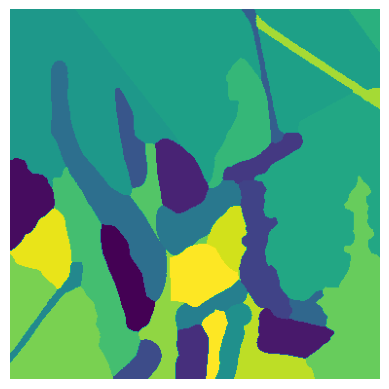

In [12]:
config['lime_segmentation']['all_dseg'] = True

data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    dim = (data.shape[0], data.shape[1])
elif config["model_to_explain"]["ResNet"]:
    dim = (data.shape[1], data.shape[2])
else:
    dim = (data['pixel_values'][0].shape[1], data['pixel_values'][0].shape[2])

plt.imshow(segment_seed(data, path_image_id, config, feature_extractor, model, dim))
plt.axis('off')

100%|██████████| 256/256 [00:19<00:00, 13.18it/s]


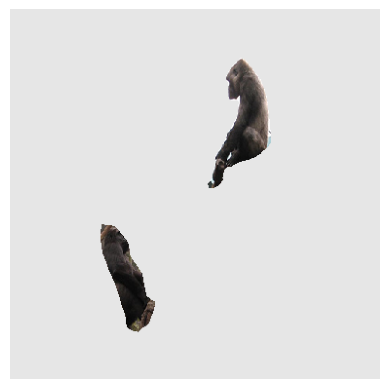

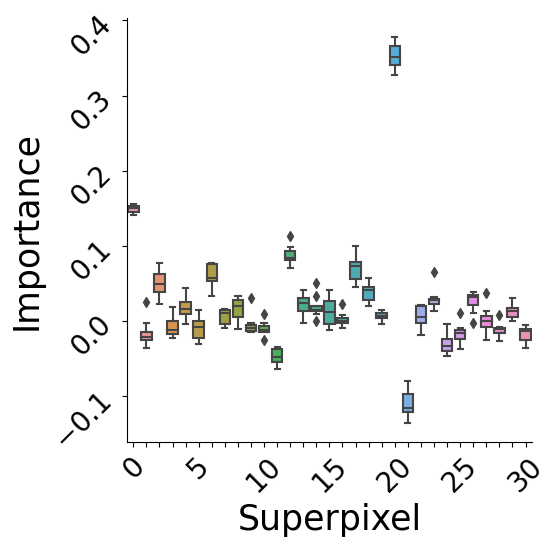

In [5]:
results_dictionary = {}

explainer = LimeImageExplainerDynamicExperimentation()

for i in range(8):
    
    data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
    if config['lime_segmentation']['all_dseg']:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                feature_extractor,
                                                model,
                                                config = config,
                                                shuffle = config['lime_segmentation']['shuffle'],
                                                image_path = path_image_id, 
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                iterations= config['lime_segmentation']['iterations'],
                                                segmentation_fn_seed = segment_seed_dynamic,
                                                segmentation_fn_dynamic = segment_image_dynamic,
                                                random_seed = 42)
    else:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                None,
                                                None,
                                                config = config,
                                                segmentation_fn=lime_segmentation,
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                random_seed = 42)
        
        
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=config['lime_segmentation']['positive_only'], 
                                                num_features=config['lime_segmentation']['num_features_explanation'], 
                                                hide_rest=config['lime_segmentation']['hide_rest']) 

    black = np.array([0, 0, 0], dtype=np.uint8)
    gray = np.array([230,230,230], dtype=np.uint8)

    # Create a mask to detect all black pixels

    if config['model_to_explain']['EfficientNet']:
        changed = data_raw*mask[:,:,np.newaxis]
    elif config['model_to_explain']['ResNet']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    elif config['model_to_explain']['VisionTransformer']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    changed = changed.astype(np.uint8)
    for i in range(changed.shape[0]):
        for j in range(changed.shape[1]):
            if (changed[i,j] == black).all():
                changed[i,j] = gray     
        
    labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

    for j in range(len(labels)):
        if labels[j] not in results_dictionary:
            # Directly assign the value if the label is new
            results_dictionary[labels[j]] = np.array([values[j]])
        else:
            # Concatenate the new value in a proper way
            results_dictionary[labels[j]] = np.concatenate((results_dictionary[labels[j]], [values[j]]))
            
plt.imshow(changed)
plt.axis('off') # Display the plots
plt.show()            

df_data_dseg = []
for category, values in results_dictionary.items():
    for observation in values:
        df_data_dseg.append({'Superpixel': category, 'Importance': observation})

# Convert to DataFrame
df = pd.DataFrame(df_data_dseg)

# Now create the catplot with Seaborn
g = sns.catplot(x='Superpixel', y='Importance', data=df, kind='box', aspect=1, height=5)

plt.xticks(rotation=45, fontsize = 20)
plt.yticks(rotation=45, fontsize = 20)
# Access the current figure and axes for manipulation
ax = g.ax

# Only display every 4th label on the x-axis
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 != 0:  # Hide labels that are not multiples of 4
        label.set_visible(False)
        
plt.xlabel('Superpixel', fontsize=25)
plt.ylabel('Importance', fontsize=25)

plt.show()

# SLIC

(-0.5, 379.5, 379.5, -0.5)

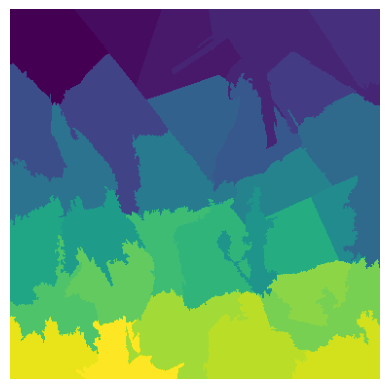

In [10]:
config['lime_segmentation']['all_dseg'] = False

config['lime_segmentation']['slic'] = True
config['lime_segmentation']['quickshift'] = False
config['lime_segmentation']['felzenszwalb'] = False
config['lime_segmentation']['watershed'] = False

config['lime_segmentation']['slic_compactness'] = 24
config['lime_segmentation']['num_segments'] = 30

data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    data_transformed_lime = data.copy()
elif config["model_to_explain"]["ResNet"]:
    data_transformed_lime = data.clone().detach().numpy()
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
else:
    data_transformed_lime= data.copy()
    data_transformed_lime = np.array(data_transformed_lime['pixel_values'][0])
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
            
lime_segments = lime_segmentation(data_transformed_lime, config)
plt.imshow(lime_segments)
plt.axis('off')

100%|██████████| 256/256 [00:18<00:00, 13.49it/s]


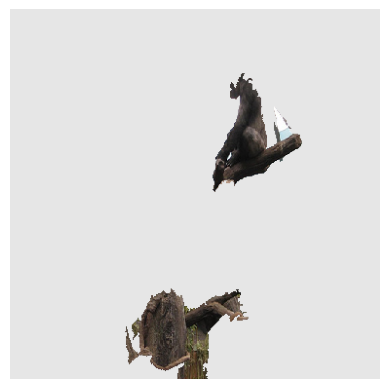

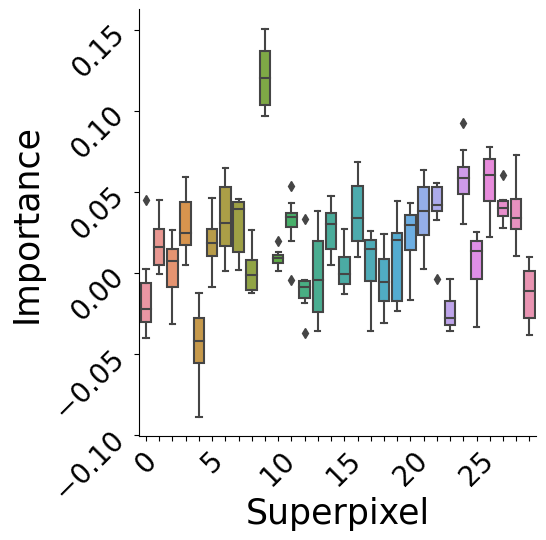

In [6]:
results_dictionary = {}

explainer = LimeImageExplainer()

for i in range(8):
    
    data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
    if config['lime_segmentation']['all_dseg']:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                feature_extractor,
                                                model,
                                                config = config,
                                                shuffle = config['lime_segmentation']['shuffle'],
                                                image_path = path_image_id, 
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                iterations= config['lime_segmentation']['iterations'],
                                                segmentation_fn_seed = segment_seed_dynamic,
                                                segmentation_fn_dynamic = segment_image_dynamic,
                                                random_seed = 42)
    else:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                None,
                                                None,
                                                config = config,
                                                segmentation_fn=lime_segmentation,
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                random_seed = 42)
        
        
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=config['lime_segmentation']['positive_only'], 
                                                num_features=config['lime_segmentation']['num_features_explanation'], 
                                                hide_rest=config['lime_segmentation']['hide_rest']) 

    black = np.array([0, 0, 0], dtype=np.uint8)
    gray = np.array([230,230,230], dtype=np.uint8)

    # Create a mask to detect all black pixels

    if config['model_to_explain']['EfficientNet']:
        changed = data_raw*mask[:,:,np.newaxis]
    elif config['model_to_explain']['ResNet']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    elif config['model_to_explain']['VisionTransformer']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    changed = changed.astype(np.uint8)
    for i in range(changed.shape[0]):
        for j in range(changed.shape[1]):
            if (changed[i,j] == black).all():
                changed[i,j] = gray     
        
    labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

    for j in range(len(labels)):
        if labels[j] not in results_dictionary:
            # Directly assign the value if the label is new
            results_dictionary[labels[j]] = np.array([values[j]])
        else:
            # Concatenate the new value in a proper way
            results_dictionary[labels[j]] = np.concatenate((results_dictionary[labels[j]], [values[j]]))
            
plt.imshow(changed)
plt.axis('off') # Display the plots
plt.show()            

df_data_slic = []
for category, values in results_dictionary.items():
    for observation in values:
        df_data_slic.append({'Superpixel': category, 'Importance': observation})

# Convert to DataFrame
df = pd.DataFrame(df_data_slic)

# Now create the catplot with Seaborn
g = sns.catplot(x='Superpixel', y='Importance', data=df, kind='box', aspect=1, height=5)

plt.xticks(rotation=45, fontsize = 20)
plt.yticks(rotation=45, fontsize = 20)
# Access the current figure and axes for manipulation
ax = g.ax

# Only display every 4th label on the x-axis
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 != 0:  # Hide labels that are not multiples of 4
        label.set_visible(False)
        
plt.xlabel('Superpixel', fontsize=25)
plt.ylabel('Importance', fontsize=25)

plt.show()

# Quickshift

(-0.5, 379.5, 379.5, -0.5)

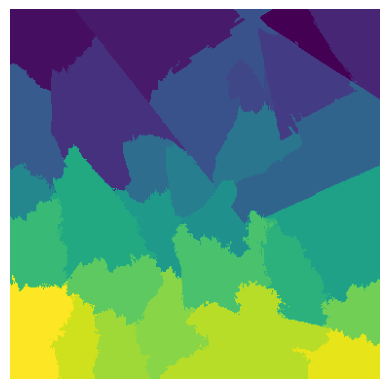

In [13]:
config['lime_segmentation']['all_dseg'] = False

explainer = LimeImageExplainer()

config['lime_segmentation']['slic'] = False
config['lime_segmentation']['quickshift'] = True
config['lime_segmentation']['felzenszwalb'] = False
config['lime_segmentation']['watershed'] = False

config['lime_segmentation']['slic_compactness'] = 24
config['lime_segmentation']['num_segments'] = 30
config['lime_segmentation']['markers'] = 16
config['lime_segmentation']['kernel_size'] = 8
config['lime_segmentation']['max_dist'] = 32

data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    data_transformed_lime = data.copy()
elif config["model_to_explain"]["ResNet"]:
    data_transformed_lime = data.clone().detach().numpy()
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
else:
    data_transformed_lime= data.copy()
    data_transformed_lime = np.array(data_transformed_lime['pixel_values'][0])
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
            
lime_segments = lime_segmentation(data_transformed_lime, config)
plt.imshow(lime_segments)
plt.axis('off')

100%|██████████| 256/256 [00:18<00:00, 13.58it/s]


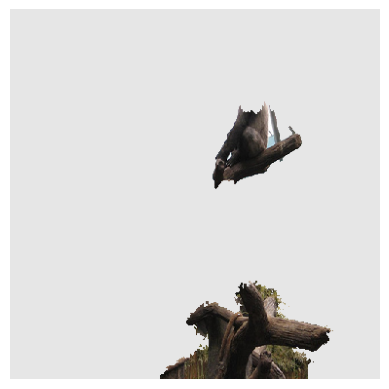

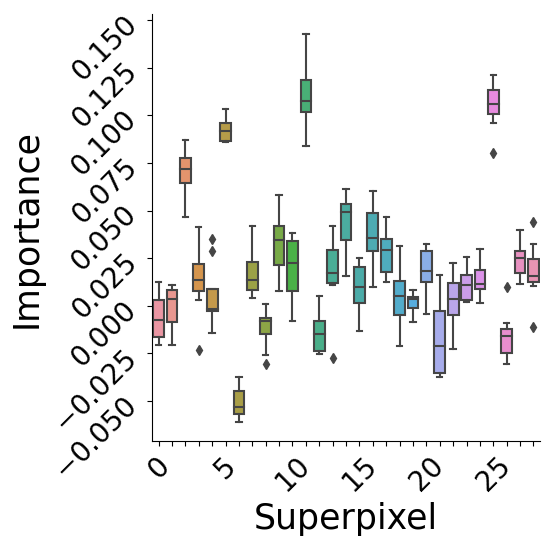

In [7]:
results_dictionary = {}

for i in range(8):
    
    data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
    if config['lime_segmentation']['all_dseg']:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                feature_extractor,
                                                model,
                                                config = config,
                                                shuffle = config['lime_segmentation']['shuffle'],
                                                image_path = path_image_id, 
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                iterations= config['lime_segmentation']['iterations'],
                                                segmentation_fn_seed = segment_seed_dynamic,
                                                segmentation_fn_dynamic = segment_image_dynamic,
                                                random_seed = 42)
    else:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                None,
                                                None,
                                                config = config,
                                                segmentation_fn=lime_segmentation,
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                random_seed = 42)
        
        
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=config['lime_segmentation']['positive_only'], 
                                                num_features=config['lime_segmentation']['num_features_explanation'], 
                                                hide_rest=config['lime_segmentation']['hide_rest']) 

    black = np.array([0, 0, 0], dtype=np.uint8)
    gray = np.array([230,230,230], dtype=np.uint8)

    # Create a mask to detect all black pixels

    if config['model_to_explain']['EfficientNet']:
        changed = data_raw*mask[:,:,np.newaxis]
    elif config['model_to_explain']['ResNet']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    elif config['model_to_explain']['VisionTransformer']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    changed = changed.astype(np.uint8)
    for i in range(changed.shape[0]):
        for j in range(changed.shape[1]):
            if (changed[i,j] == black).all():
                changed[i,j] = gray     
        
    labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

    for j in range(len(labels)):
        if labels[j] not in results_dictionary:
            # Directly assign the value if the label is new
            results_dictionary[labels[j]] = np.array([values[j]])
        else:
            # Concatenate the new value in a proper way
            results_dictionary[labels[j]] = np.concatenate((results_dictionary[labels[j]], [values[j]]))
            
plt.imshow(changed)
plt.axis('off') # Display the plots
plt.show()            

df_data_qs = []
for category, values in results_dictionary.items():
    for observation in values:
        df_data_qs.append({'Superpixel': category, 'Importance': observation})

# Convert to DataFrame
df = pd.DataFrame(df_data_qs)

# Now create the catplot with Seaborn
g = sns.catplot(x='Superpixel', y='Importance', data=df, kind='box', aspect=1, height=5)

plt.xticks(rotation=45, fontsize = 20)
plt.yticks(rotation=45, fontsize = 20)
# Access the current figure and axes for manipulation
ax = g.ax

# Only display every 4th label on the x-axis
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 != 0:  # Hide labels that are not multiples of 4
        label.set_visible(False)
        
plt.xlabel('Superpixel', fontsize=25)
plt.ylabel('Importance', fontsize=25)

plt.show()

# Felzenszwalb

(-0.5, 379.5, 379.5, -0.5)

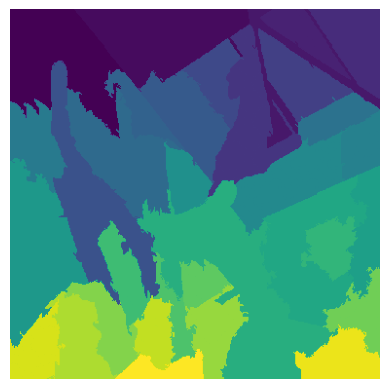

In [15]:
config['lime_segmentation']['all_dseg'] = False

explainer = LimeImageExplainer()

config['lime_segmentation']['slic'] = False
config['lime_segmentation']['quickshift'] = False
config['lime_segmentation']['felzenszwalb'] = True
config['lime_segmentation']['watershed'] = False

config['lime_segmentation']['slic_compactness'] = 24
config['lime_segmentation']['num_segments'] = 30
config['lime_segmentation']['markers'] = 16
config['lime_segmentation']['kernel_size'] = 6
config['lime_segmentation']['min_size'] = 1024
config['lime_segmentation']['max_dist'] = 32

data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    data_transformed_lime = data.copy()
elif config["model_to_explain"]["ResNet"]:
    data_transformed_lime = data.clone().detach().numpy()
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
else:
    data_transformed_lime= data.copy()
    data_transformed_lime = np.array(data_transformed_lime['pixel_values'][0])
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
            
lime_segments = lime_segmentation(data_transformed_lime, config)
plt.imshow(lime_segments)
plt.axis('off')

100%|██████████| 256/256 [00:18<00:00, 13.63it/s]


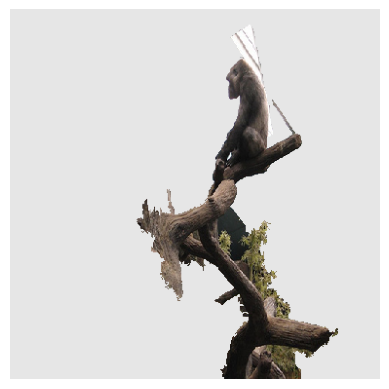

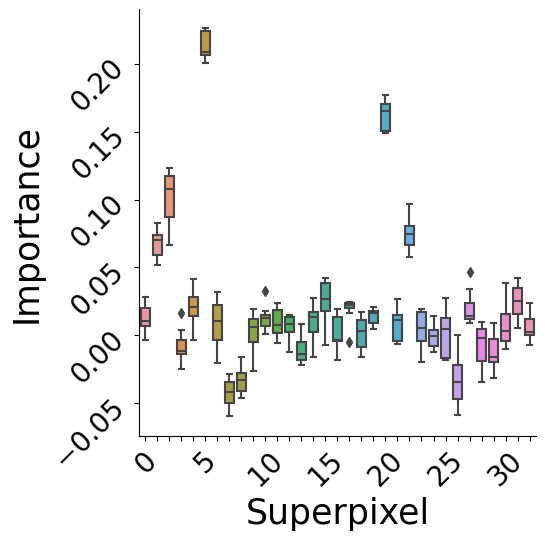

In [9]:
results_dictionary = {}

for i in range(8):
    
    data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
    if config['lime_segmentation']['all_dseg']:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                feature_extractor,
                                                model,
                                                config = config,
                                                shuffle = config['lime_segmentation']['shuffle'],
                                                image_path = path_image_id, 
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                iterations= config['lime_segmentation']['iterations'],
                                                segmentation_fn_seed = segment_seed_dynamic,
                                                segmentation_fn_dynamic = segment_image_dynamic,
                                                random_seed = 42)
    else:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                None,
                                                None,
                                                config = config,
                                                segmentation_fn=lime_segmentation,
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                random_seed = 42)
        
        
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=config['lime_segmentation']['positive_only'], 
                                                num_features=config['lime_segmentation']['num_features_explanation'], 
                                                hide_rest=config['lime_segmentation']['hide_rest']) 

    black = np.array([0, 0, 0], dtype=np.uint8)
    gray = np.array([230,230,230], dtype=np.uint8)

    # Create a mask to detect all black pixels

    if config['model_to_explain']['EfficientNet']:
        changed = data_raw*mask[:,:,np.newaxis]
    elif config['model_to_explain']['ResNet']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    elif config['model_to_explain']['VisionTransformer']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    changed = changed.astype(np.uint8)
    for i in range(changed.shape[0]):
        for j in range(changed.shape[1]):
            if (changed[i,j] == black).all():
                changed[i,j] = gray     
        
    labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

    for j in range(len(labels)):
        if labels[j] not in results_dictionary:
            # Directly assign the value if the label is new
            results_dictionary[labels[j]] = np.array([values[j]])
        else:
            # Concatenate the new value in a proper way
            results_dictionary[labels[j]] = np.concatenate((results_dictionary[labels[j]], [values[j]]))
            
plt.imshow(changed)
plt.axis('off') # Display the plots
plt.show()            

df_data_fs = []
for category, values in results_dictionary.items():
    for observation in values:
        df_data_fs.append({'Superpixel': category, 'Importance': observation})

# Convert to DataFrame
df = pd.DataFrame(df_data_fs)

# Now create the catplot with Seaborn
g = sns.catplot(x='Superpixel', y='Importance', data=df, kind='box', aspect=1, height=5)

plt.xticks(rotation=45, fontsize = 20)
plt.yticks(rotation=45, fontsize = 20)
# Access the current figure and axes for manipulation
ax = g.ax

# Only display every 4th label on the x-axis
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 != 0:  # Hide labels that are not multiples of 4
        label.set_visible(False)
        
plt.xlabel('Superpixel', fontsize=25)
plt.ylabel('Importance', fontsize=25)

plt.show()

# Watershed

(-0.5, 379.5, 379.5, -0.5)

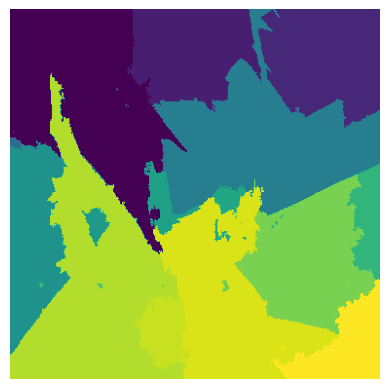

In [14]:
config['lime_segmentation']['all_dseg'] = False

explainer = LimeImageExplainer()

config['lime_segmentation']['slic'] = False
config['lime_segmentation']['quickshift'] = False
config['lime_segmentation']['felzenszwalb'] = False
config['lime_segmentation']['watershed'] = True

config['lime_segmentation']['slic_compactness'] = 24
config['lime_segmentation']['num_segments'] = 30
config['lime_segmentation']['markers'] = 36
config['lime_segmentation']['kernel_size'] = 6
config['lime_segmentation']['max_dist'] = 32

data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    data_transformed_lime = data.copy()
elif config["model_to_explain"]["ResNet"]:
    data_transformed_lime = data.clone().detach().numpy()
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
else:
    data_transformed_lime= data.copy()
    data_transformed_lime = np.array(data_transformed_lime['pixel_values'][0])
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
            
lime_segments = lime_segmentation(data_transformed_lime, config)
plt.imshow(lime_segments)
plt.axis('off')

100%|██████████| 256/256 [00:18<00:00, 13.92it/s]


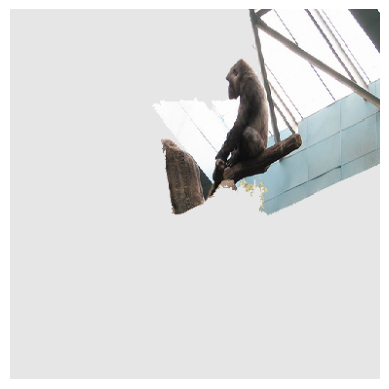

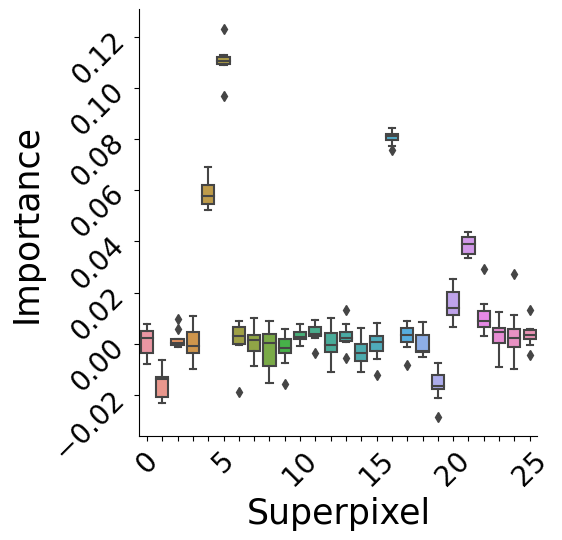

In [8]:
results_dictionary = {}

for i in range(8):
    
    data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
    if config['lime_segmentation']['all_dseg']:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                feature_extractor,
                                                model,
                                                config = config,
                                                shuffle = config['lime_segmentation']['shuffle'],
                                                image_path = path_image_id, 
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                iterations= config['lime_segmentation']['iterations'],
                                                segmentation_fn_seed = segment_seed_dynamic,
                                                segmentation_fn_dynamic = segment_image_dynamic,
                                                random_seed = 42)
    else:
        explanation = explainer.explain_instance(data, 
                                                model_explain,
                                                None,
                                                None,
                                                config = config,
                                                segmentation_fn=lime_segmentation,
                                                top_labels=config['lime_segmentation']['top_labels'], 
                                                hide_color=config['lime_segmentation']['hide_color'], 
                                                num_samples=config['lime_segmentation']['num_samples'],
                                                random_seed = 42)
        
        
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=config['lime_segmentation']['positive_only'], 
                                                num_features=config['lime_segmentation']['num_features_explanation'], 
                                                hide_rest=config['lime_segmentation']['hide_rest']) 

    black = np.array([0, 0, 0], dtype=np.uint8)
    gray = np.array([230,230,230], dtype=np.uint8)

    # Create a mask to detect all black pixels

    if config['model_to_explain']['EfficientNet']:
        changed = data_raw*mask[:,:,np.newaxis]
    elif config['model_to_explain']['ResNet']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    elif config['model_to_explain']['VisionTransformer']:
        data_local = data_raw.resize((mask.shape[0],mask.shape[1]))
        changed = data_local*mask[:,:,np.newaxis]
    changed = changed.astype(np.uint8)
    for i in range(changed.shape[0]):
        for j in range(changed.shape[1]):
            if (changed[i,j] == black).all():
                changed[i,j] = gray     
        
    labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

    for j in range(len(labels)):
        if labels[j] not in results_dictionary:
            # Directly assign the value if the label is new
            results_dictionary[labels[j]] = np.array([values[j]])
        else:
            # Concatenate the new value in a proper way
            results_dictionary[labels[j]] = np.concatenate((results_dictionary[labels[j]], [values[j]]))
            
plt.imshow(changed)
plt.axis('off') # Display the plots
plt.show()            

df_data_ws = []
for category, values in results_dictionary.items():
    for observation in values:
        df_data_ws.append({'Superpixel': category, 'Importance': observation})

# Convert to DataFrame
df = pd.DataFrame(df_data_ws)

# Now create the catplot with Seaborn
g = sns.catplot(x='Superpixel', y='Importance', data=df, kind='box', aspect=1, height=5)

plt.xticks(rotation=45, fontsize = 20)
plt.yticks(rotation=45, fontsize = 20)
# Access the current figure and axes for manipulation
ax = g.ax

# Only display every 4th label on the x-axis
for index, label in enumerate(ax.get_xticklabels()):
    if index % 5 != 0:  # Hide labels that are not multiples of 4
        label.set_visible(False)
        
plt.xlabel('Superpixel', fontsize=25)
plt.ylabel('Importance', fontsize=25)

plt.show()